DepReader4を採用

In [1]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from lambeq import AtomicType, IQPAnsatz, NumpyModel, BinaryCrossEntropyLoss, QuantumTrainer, SPSAOptimizer, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

n, s = Ty('n'), Ty('s')
# nlp = spacy.load("ja_core_web_sm")
nlp = spacy.load("en_core_web_trf")

c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\thinc\shims\pytorch.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the

In [2]:
# データセット読み込み
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            # labels.append([[0, t],[0, 1-t]]) # 2×2行列の形で格納するならこっち
            labels.append([1-t, t]) # 1×2行列の形
            sentences.append(line[1:].strip())
            
    return np.array(labels), sentences

train_labels, train_sentences = read_data('C:/Users/neoia//研究/mc_train_data.txt')
dev_labels, dev_sentences = read_data('C:/Users/neoia//研究/mc_dev_data.txt')
test_labels, test_sentences = read_data('C:/Users/neoia//研究/mc_test_data.txt')


In [3]:
train_sentences

['skillful man prepares sauce .',
 'skillful man bakes dinner .',
 'woman cooks tasty meal .',
 'man prepares meal .',
 'skillful woman debugs program .',
 'woman prepares tasty meal .',
 'person runs program .',
 'person runs useful application .',
 'woman prepares sauce .',
 'woman prepares dinner .',
 'skillful person prepares meal .',
 'skillful person bakes dinner .',
 'skillful woman bakes meal .',
 'woman runs useful application .',
 'man bakes tasty meal .',
 'person prepares tasty meal .',
 'woman runs application .',
 'man prepares software .',
 'man bakes tasty dinner .',
 'person prepares useful program .',
 'man debugs useful application .',
 'person debugs useful application .',
 'woman prepares program .',
 'man prepares useful application .',
 'skillful man cooks dinner .',
 'man debugs useful software .',
 'person cooks dinner .',
 'skillful woman prepares meal .',
 'man prepares application .',
 'person debugs useful software .',
 'person runs application .',
 'skillf

In [7]:
# 型の割り当て
def assign_types(doc):
    pregroup_types = {}
    doc = nlp(sentence)
    # トークン化
    tokens = [token.text for token in doc]
    # 依存関係をまとめる
    # dependencies = [(token.text, token.head.text) for token in doc if token.text != "."]
    dependencies = []
    
    for token in doc:
        if token.dep_ == 'ROOT':
            pregroup_types[token.text] = s
            dependencies.append((token.text, token.head.text))
        elif token.pos_ == 'NOUN' or token.pos_ == 'PRON' or token.pos_ == 'PROPN':
            pregroup_types[token.text] = n
            if token.head.dep_ == 'ROOT':
                dependencies.append((token.text, token.head.text))

    # 依存関係による型の割り当て（ペアと語順）
    for token in doc:
        for dep in dependencies:
            if token.text == dep[1]:
                idx1 = tokens.index(dep[0])
                idx2 = tokens.index(dep[1])
                if pregroup_types[dep[0]] == n:
                    if idx1 < idx2:
                        pregroup_types[token.text] = n.r @ pregroup_types[token.text]
                    else:
                        pregroup_types[token.text] = pregroup_types[token.text] @ n.l
                # elif pregroup_types[dep[0]] == s:
                    # if idx1 < idx2:
                        # pregroup_types[token.text] = s.r @ pregroup_types[token.text]
                    # else:
                        # pregroup_types[token.text] = pregroup_types[token.text] @ s.l
    
    return pregroup_types

In [8]:
# creating diagram
def create_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = assign_types(doc)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # making cups
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

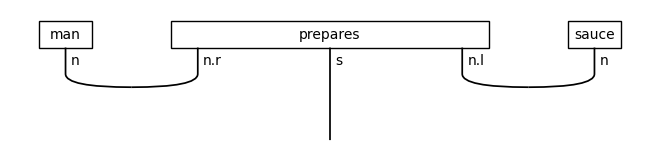

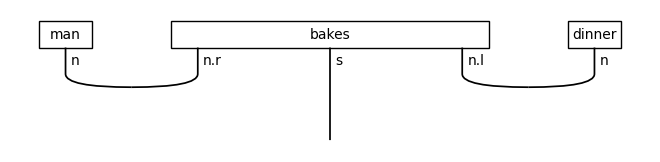

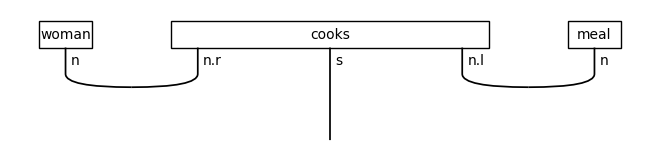

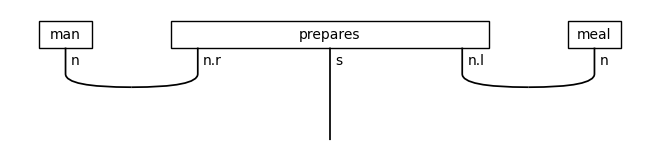

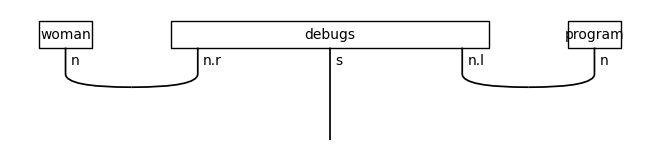

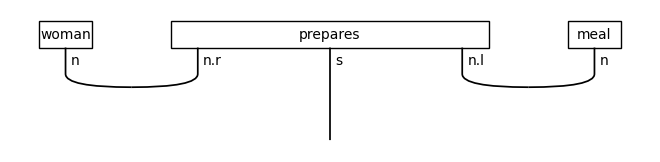

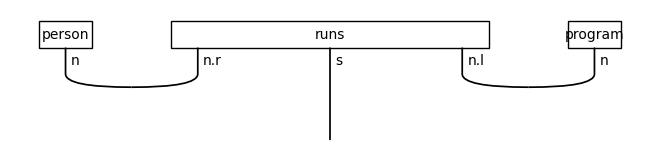

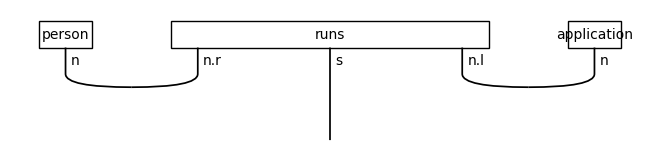

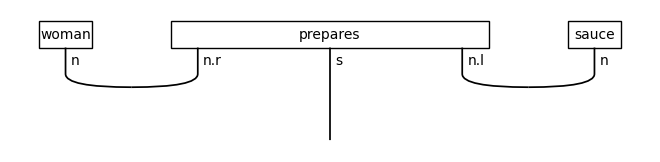

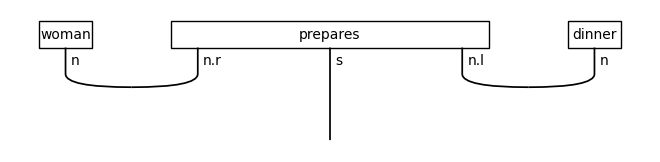

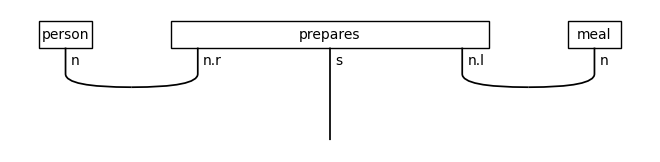

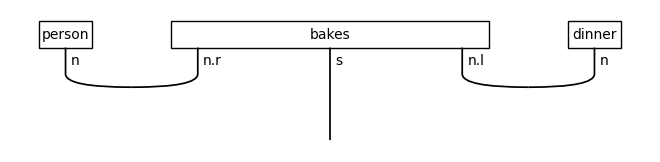

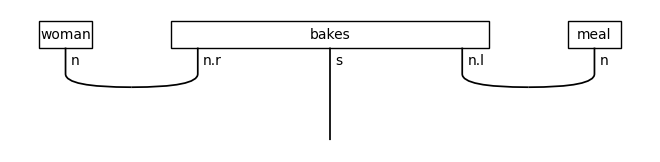

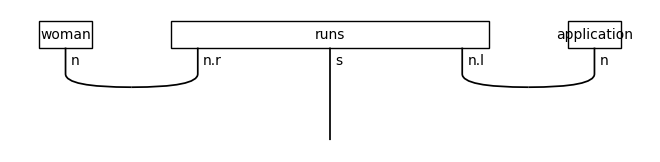

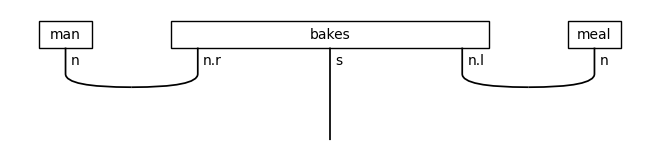

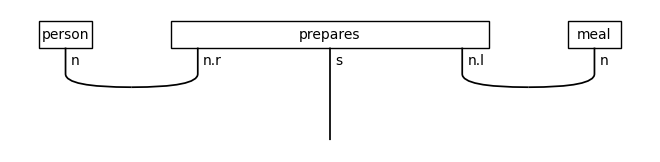

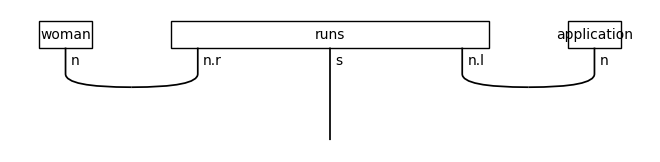

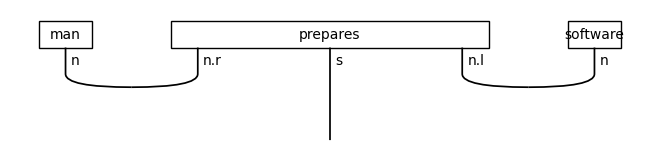

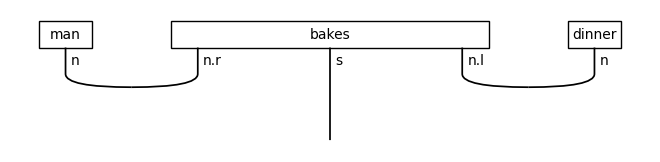

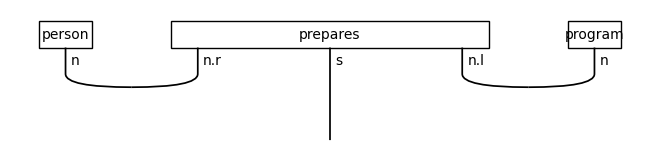

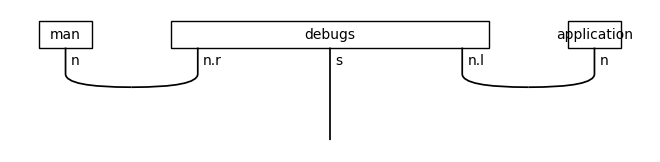

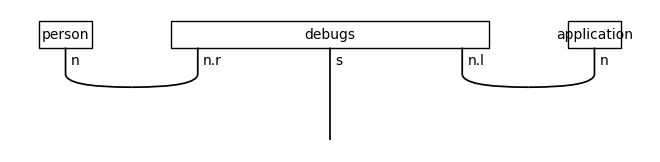

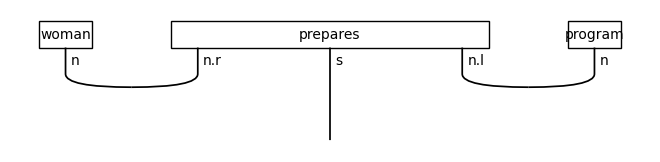

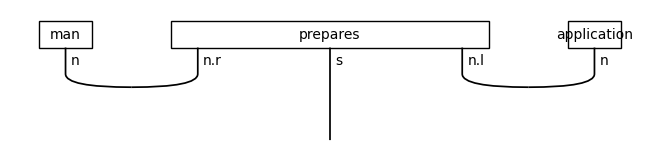

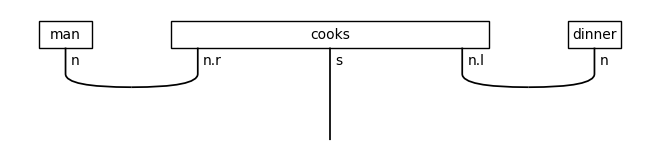

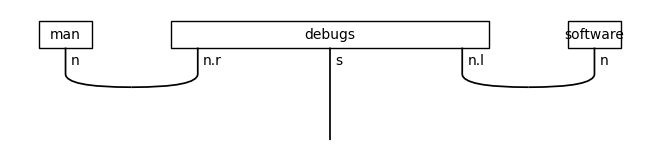

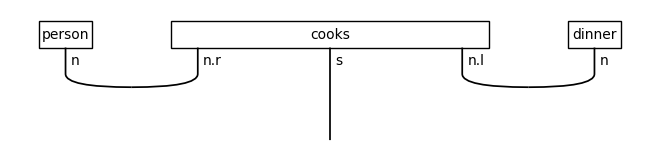

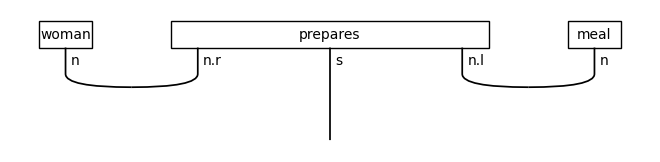

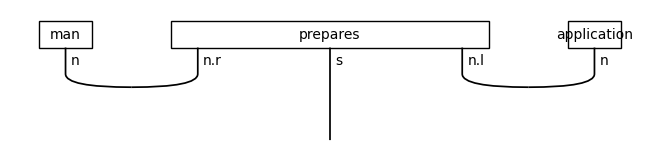

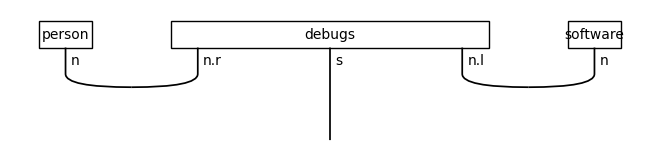

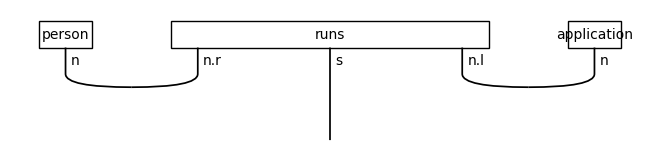

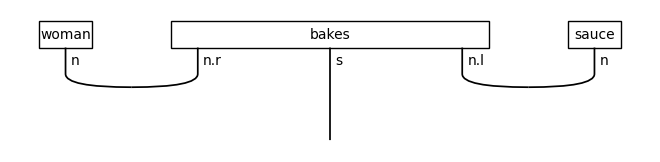

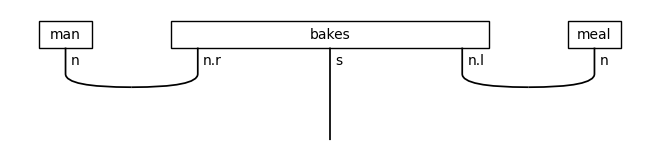

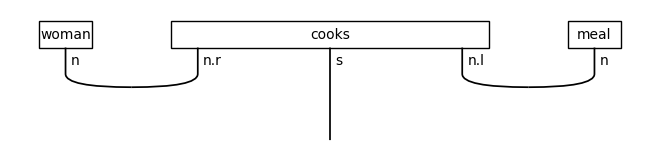

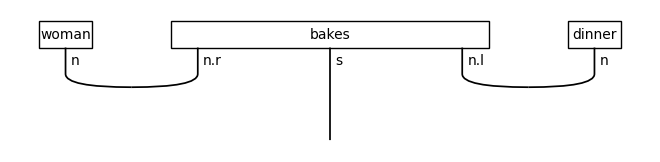

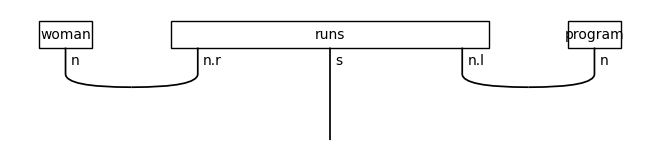

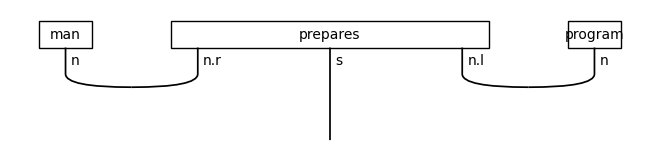

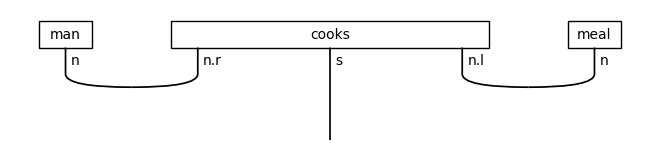

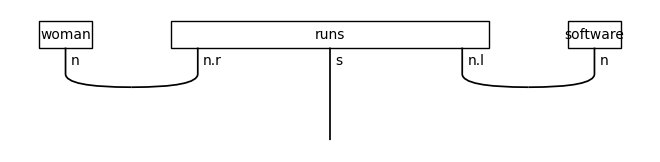

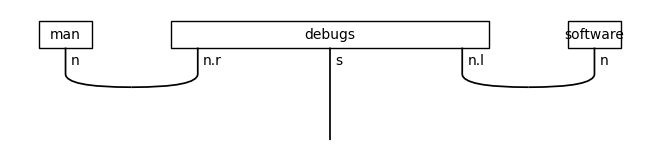

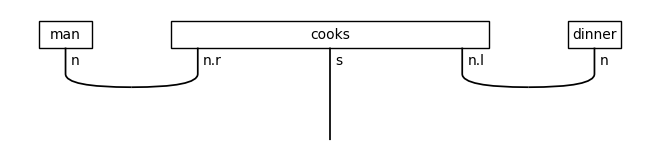

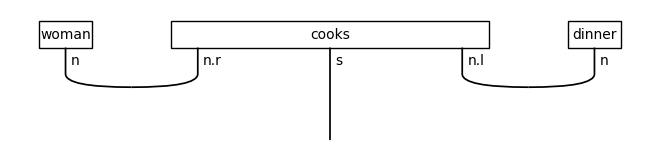

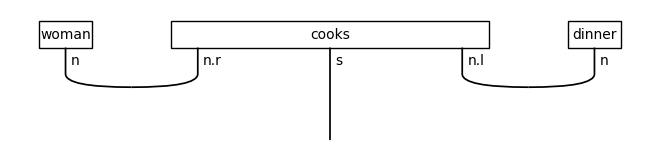

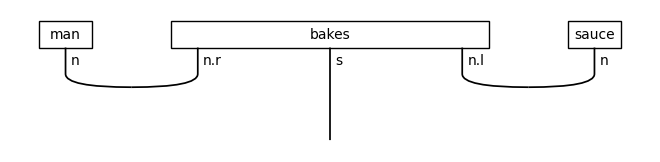

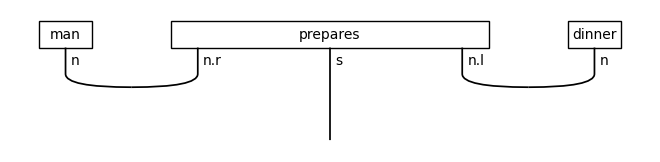

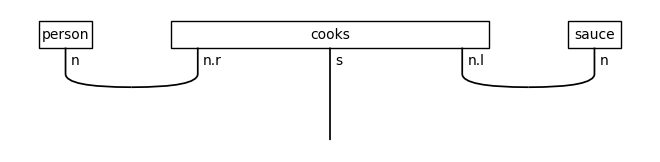

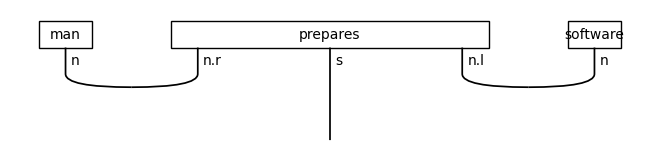

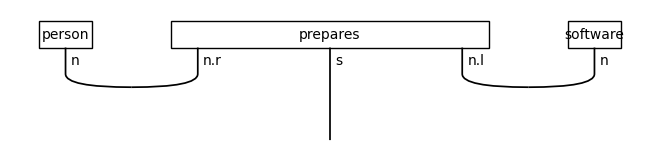

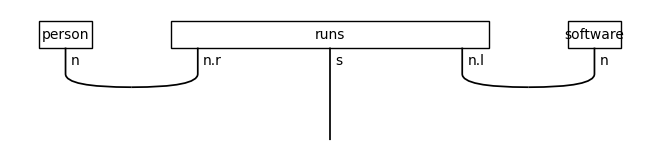

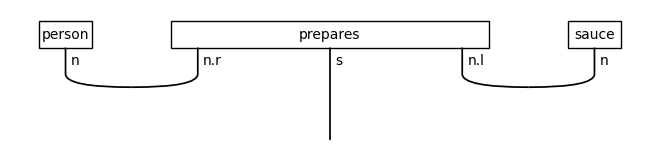

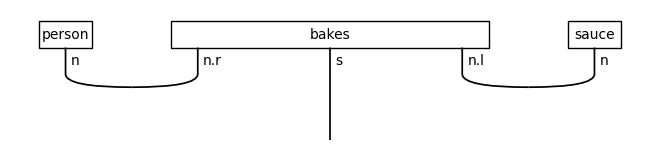

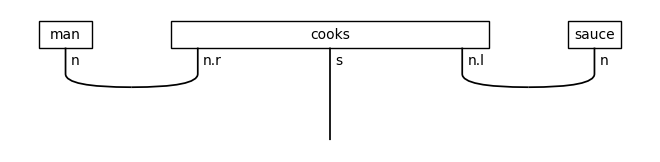

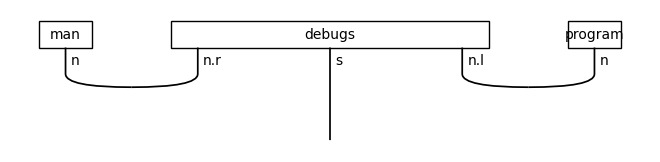

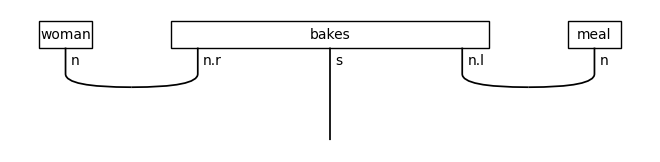

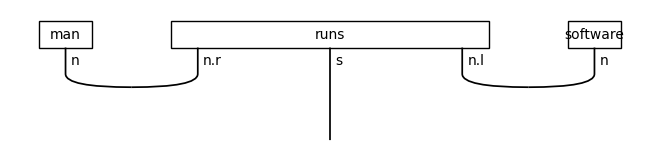

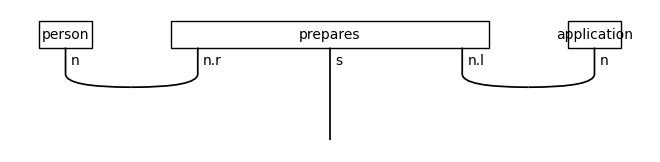

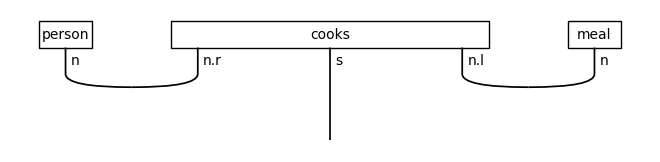

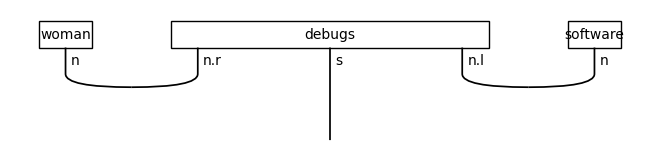

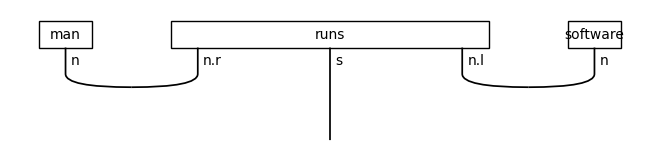

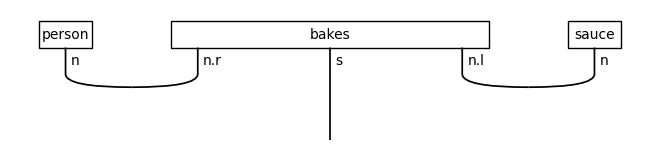

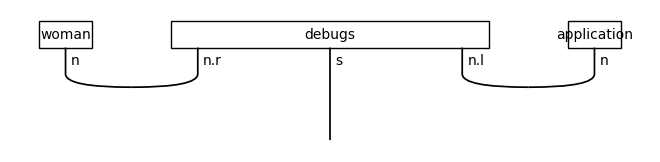

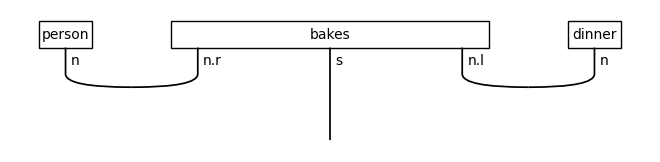

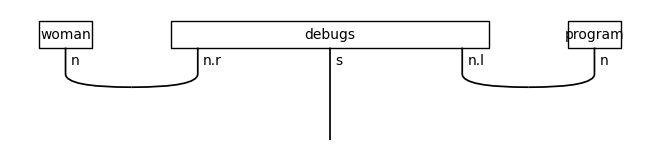

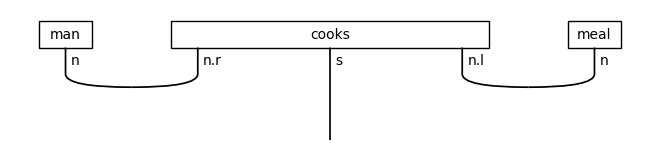

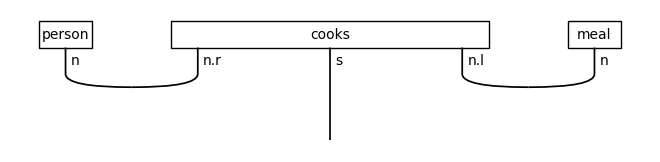

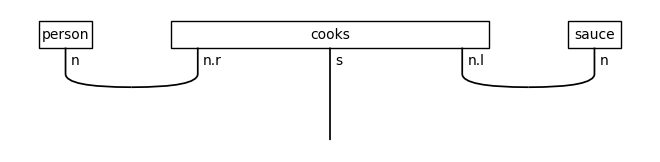

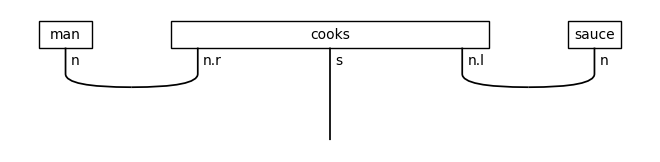

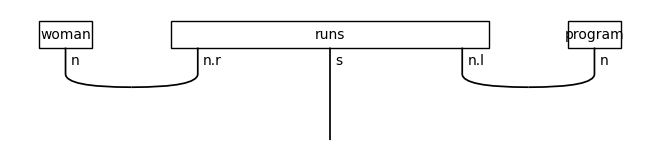

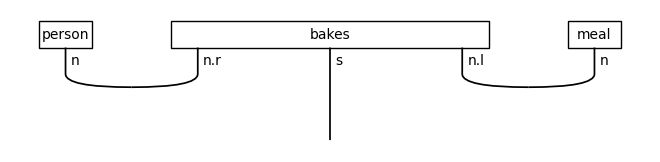

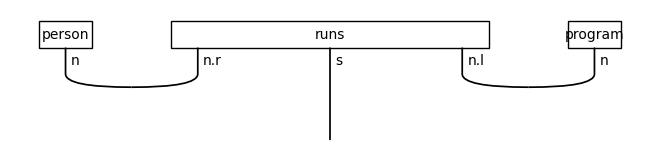

In [9]:
train_diagrams = []
dev_diagrams = []
test_diagrams = []

for i in range(len(train_sentences)):
    sentence = train_sentences[i]
    train_diagrams.append(create_diagram(sentence))
for i in range(len(dev_sentences)):
    sentence = dev_sentences[i]
    dev_diagrams.append(create_diagram(sentence))
for i in range(len(test_sentences)):
    sentence = test_sentences[i]
    test_diagrams.append(create_diagram(sentence))

# check diagrams
for d in range(len(train_sentences)):
    draw(train_diagrams[d])

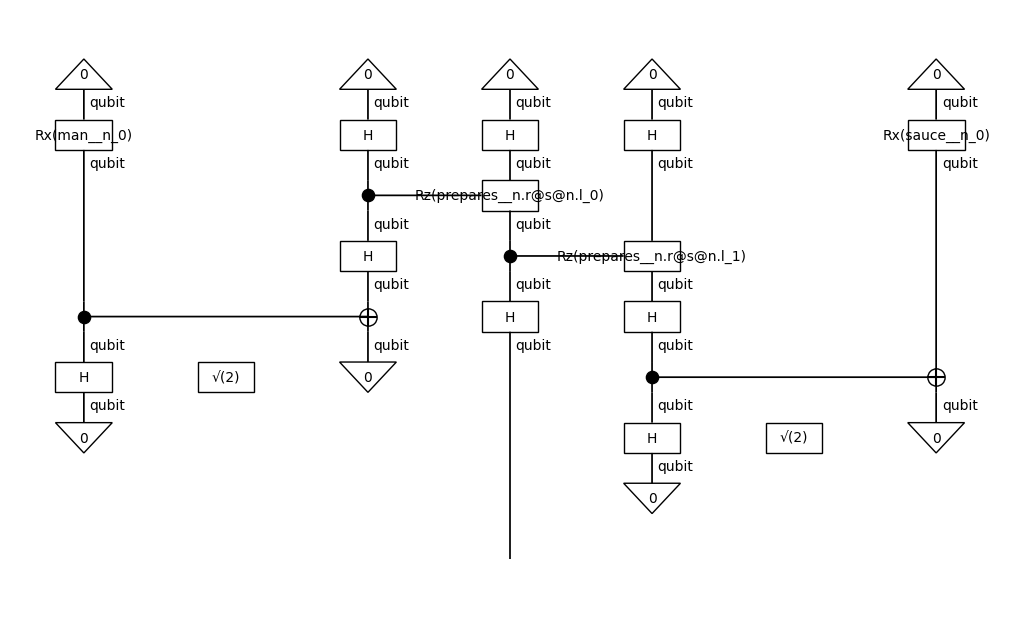

In [10]:
# 量子回路設計（IQPAnsatz）
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=1)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(10, 6))

In [11]:
# 量子回路シミュレーションをする計算モデルを構築
all_circuits = train_circuits + dev_circuits + test_circuits # モデル初期化時に全量子回路を提供するための準備
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

# 損失関数と予測精度の定義
bce = BinaryCrossEntropyLoss(use_jax=True)
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2
# roundで四捨五入して0or1に変換  # 正解数を総数で割る

In [12]:
# ハイパーパラメータ
BATCH_SIZE = 30
# LEARNING_RATE = 3e-2
EPOCHS = 400
SEED = 0

# trainerの定義
trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.1, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=SEED
)

train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [13]:
trainer.fit(train_dataset, val_dataset, log_interval=100)

Epoch 100:  train/loss: 0.0542   valid/loss: 0.0333   train/time: 13.85s   valid/time: 2.68s   train/acc: 1.0000   valid/acc: 1.0000
Epoch 200:  train/loss: 0.0190   valid/loss: 0.0079   train/time: 7.67s   valid/time: 2.01s   train/acc: 1.0000   valid/acc: 1.0000
Epoch 300:  train/loss: 0.0173   valid/loss: 0.0054   train/time: 8.40s   valid/time: 2.25s   train/acc: 1.0000   valid/acc: 1.0000
Epoch 400:  train/loss: 0.0124   valid/loss: 0.0047   train/time: 7.79s   valid/time: 2.05s   train/acc: 1.0000   valid/acc: 1.0000

Training completed!
train/time: 37.71s   train/time_per_epoch: 0.09s   train/time_per_step: 0.03s   valid/time: 9.00s   valid/time_per_eval: 0.02s


Train accuracy: 1.0
Test accuracy: 1.0


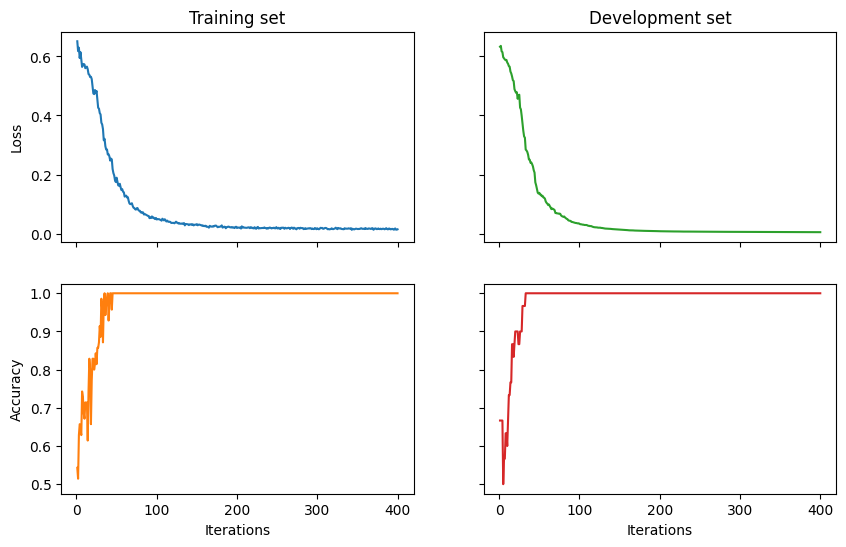

In [14]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

train_acc = acc(model(train_circuits), np.array(train_labels))
test_acc = acc(model(test_circuits), np.array(test_labels))
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)